<a href="https://colab.research.google.com/github/eaklykova/neuromethods/blob/main/hw4/klykova_nn_methods_hw4_bert_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Д/З 4: использование BERT для классификации последовательности
### Выполнила Елизавета Клыкова, БКЛ181

## Импорт библиотек

In [1]:
!pip install -q transformers
!pip install -q datasets

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, Trainer, TrainingArguments, \
    BertForSequenceClassification

import numpy as np
import pandas as pd
import seaborn as sns

from pylab import rcParams
from textwrap import wrap
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_fscore_support, accuracy_score

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset

In [3]:
seed = 117
# random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available()\
                              else torch.device('cpu')
DEVICE

device(type='cuda')

## Загрузка датасета

In [5]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 74.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 167MB/s]


In [6]:
df = pd.read_csv("reviews.csv")

Смотрим на распределение классов, балансируем датасет:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'review score')

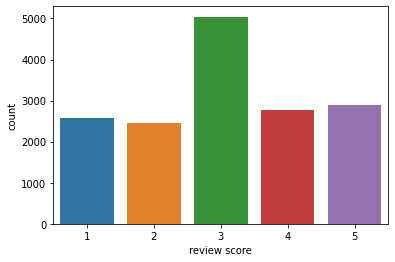

In [7]:
sns.countplot(df.score)
plt.xlabel('review score')

In [8]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

In [9]:
df['sentiment'] = df.score.apply(to_sentiment)

In [10]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

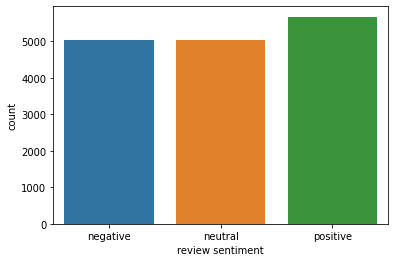

In [11]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Требования
Решите задачу классификации по тональности на подготовленном в тетрадке корпусе, используя пайплайн с Trainer от HuggingFace.

1. DONE обучите ту модель, которую мы разбирали на занятии (класс SentimentClassifier из тетрадки) -- 2 балла

2. DONE измените модель, чтобы помимо выхода с пуллер-слоя использовался эмбеддинг cls-токена с последнего слоя. -- 3 балла

3. DONE примените к данным готовую модель для классификации последовательности (типа BertForSequenceClassification) -- 2 балла

4. DONE агрегируйте cls-токены для нескольких слоев, чтобы сделать предсказание класса -- 2 дополнительных балла

5. DONE выберите на сайте google play три понравившихся вам отзыва, относящиеся к разным классам. Покажите, как на них работает любая из обученных моделей -- 2 балла

DONE Общие требования: (1 балл) Для всех моделей используйте одинаковые гиперпараметры, чтобы их результаты можно было сравнить между собой.

DONE Комментируйте ваши решения в коде.

DONE Для каждой из моделей нужно привести результаты на тестовой выборке.

DONE Вы можете использовать любую предобученную модель, которая подходит для работы с английским, кроме bert-base-cased.

## 1: Обучить модель с SentimentClassifier (2 балла)

### Подготовка данных
Делим на тест и трейн:

In [12]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=seed)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=seed)

Я буду использовать модель [prajjwal1/bert-mini](https://huggingface.co/prajjwal1/bert-mini), поскольку она мало весит, а также быстро обучается и работает.

In [13]:
PRE_TRAINED_MODEL_NAME = 'prajjwal1/bert-mini'

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [15]:
class GPReviewDataset(torch.utils.data.Dataset):

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [16]:
train_encodings = tokenizer(df_train['content'].to_list(), truncation=True, 
                            padding=True, return_token_type_ids=False, 
                            return_attention_mask=True, max_length=160)
val_encodings = tokenizer(df_val['content'].to_list(), truncation=True, 
                          padding=True, return_token_type_ids=False,
                          return_attention_mask=True, max_length=160)
test_encodings = tokenizer(df_test['content'].to_list(), truncation=True, 
                           padding=True, return_token_type_ids=False,
                           return_attention_mask=True, max_length=160)

In [17]:
train_dataset = GPReviewDataset(train_encodings, df_train['sentiment'].to_list())
val_dataset = GPReviewDataset(val_encodings, df_val['sentiment'].to_list())
test_dataset = GPReviewDataset(test_encodings, df_test['sentiment'].to_list())

### Метрики и параметры трейнера

In [18]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds,
                                                               average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Параметры одинаковые для всех моделей, чтобы можно было сравнить результаты:

In [19]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
)

### Модель
Добавляем в модель подсчет лосса (кросс-энтропию):

In [20]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_classes = n_classes
  
    def forward(self, input_ids, attention_mask, labels=None):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False)
        output = self.drop(pooled_output)
        output = self.out(output)
        if labels is not None:
            loss_function = nn.CrossEntropyLoss()
            loss = loss_function(output, labels)
            return loss, output
        else:
            return output

In [21]:
model1 = SentimentClassifier(n_classes=3)
model1 = model1.to(DEVICE)

Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
trainer1 = Trainer(
    model=model1,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer1.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5316


Step,Training Loss
100,1.148100
200,1.111400
300,1.077900
400,0.996700
500,0.931800
600,0.968600
700,0.883900
800,0.829400
900,0.825600
1000,0.849600


Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-3000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-3500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-4000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model chec

TrainOutput(global_step=5316, training_loss=0.7124012172266987, metrics={'train_runtime': 263.8687, 'train_samples_per_second': 161.114, 'train_steps_per_second': 20.146, 'total_flos': 0.0, 'train_loss': 0.7124012172266987, 'epoch': 3.0})

### Оценка

In [23]:
trainer1.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 3.0,
 'eval_accuracy': 0.7458703939008895,
 'eval_f1': 0.7449001912160426,
 'eval_loss': 0.6661240458488464,
 'eval_precision': 0.7444538860445467,
 'eval_recall': 0.7458703939008895,
 'eval_runtime': 1.1396,
 'eval_samples_per_second': 690.617,
 'eval_steps_per_second': 43.877}

In [24]:
task1_metrics = trainer1.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
task1_metrics

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'epoch': 3.0,
 'test_accuracy': 0.7195431472081218,
 'test_f1': 0.7175250820150627,
 'test_loss': 0.700705885887146,
 'test_precision': 0.7165735299433978,
 'test_recall': 0.7195431472081218,
 'test_runtime': 1.2779,
 'test_samples_per_second': 616.649,
 'test_steps_per_second': 39.127}

'test_accuracy': 0.7195431472081218

'test_f1': 0.7175250820150627

'test_loss': 0.700705885887146

'test_precision': 0.7165735299433978

'test_recall': 0.7195431472081218

## 2: Использовать CLS-токен (3 балла)
Измените модель, чтобы помимо выхода с пуллер-слоя использовался эмбеддинг cls-токена с последнего слоя.

### Модель

In [25]:
class SentimentClassifierWithCLS(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        # в два раза больше параметров: с пуллер-слоя и CLS
        self.out = nn.Linear(self.bert.config.hidden_size * 2, n_classes)
        self.n_classes = n_classes
  
    def forward(self, input_ids, attention_mask, labels=None):
        last_hidden_state, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False)
        # добавляем выходы с CLS
        cls_hidden = last_hidden_state[:, 0, :]
        stacked_layers = torch.hstack([cls_hidden, pooled_output])
        # дальше все то же самое
        output = self.drop(stacked_layers)
        output = self.out(output)
        if labels is not None:
            loss_function = nn.CrossEntropyLoss()
            loss = loss_function(output, labels)
            return loss, output
        else:
            return output

In [26]:
model2 = SentimentClassifierWithCLS(n_classes=3)
model2 = model2.to(DEVICE)

loading configuration file https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-mini/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/3baee60ec6103a88d346bbdcc74e81e9027137f2

In [27]:
trainer2 = Trainer(
    model=model2,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer2.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5316


Step,Training Loss
100,1.142300
200,1.092300
300,1.025700
400,0.941400
500,0.910300
600,0.969300
700,0.861200
800,0.816500
900,0.841100
1000,0.834600


Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-3000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-3500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-4000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model chec

TrainOutput(global_step=5316, training_loss=0.7063673872800588, metrics={'train_runtime': 267.5421, 'train_samples_per_second': 158.902, 'train_steps_per_second': 19.87, 'total_flos': 0.0, 'train_loss': 0.7063673872800588, 'epoch': 3.0})

### Оценка

In [28]:
trainer2.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 3.0,
 'eval_accuracy': 0.7534942820838628,
 'eval_f1': 0.7510092553606023,
 'eval_loss': 0.6870903372764587,
 'eval_precision': 0.7505587063502279,
 'eval_recall': 0.7534942820838628,
 'eval_runtime': 1.14,
 'eval_samples_per_second': 690.337,
 'eval_steps_per_second': 43.859}

In [29]:
task2_metrics = trainer2.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
task2_metrics

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'epoch': 3.0,
 'test_accuracy': 0.7271573604060914,
 'test_f1': 0.7249801696477138,
 'test_loss': 0.7265090346336365,
 'test_precision': 0.7244949466213112,
 'test_recall': 0.7271573604060914,
 'test_runtime': 1.269,
 'test_samples_per_second': 620.961,
 'test_steps_per_second': 39.401}

'test_accuracy': 0.7271573604060914

'test_f1': 0.7249801696477138

'test_loss': 0.7265090346336365

'test_precision': 0.7244949466213112

'test_recall': 0.7271573604060914

## 3: Применить готовую модель BertForSequenceClassification (2 балла)

### Модель


In [30]:
model3 = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME,
                                                       num_labels=3)
model3 = model3.to(DEVICE)

loading configuration file https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://hugg

In [31]:
trainer3 = Trainer(
    model=model3,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer3.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5316


Step,Training Loss
100,1.110100
200,1.084800
300,1.044900
400,0.946800
500,0.906400
600,0.917000
700,0.845100
800,0.792400
900,0.793800
1000,0.815900


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=5316, training_loss=0.6979088459452621, metrics={'train_runtime': 270.9737, 'train_samples_per_second': 156.89, 'train_steps_per_second': 19.618, 'total_flos': 131665753915200.0, 'train_loss': 0.6979088459452621, 'epoch': 3.0})

### Оценка

In [32]:
trainer3.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 3.0,
 'eval_accuracy': 0.7433290978398983,
 'eval_f1': 0.7413411404516946,
 'eval_loss': 0.6564545631408691,
 'eval_precision': 0.740587164439763,
 'eval_recall': 0.7433290978398983,
 'eval_runtime': 1.1366,
 'eval_samples_per_second': 692.418,
 'eval_steps_per_second': 43.991}

In [33]:
task3_metrics = trainer3.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
task3_metrics

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'epoch': 3.0,
 'test_accuracy': 0.7182741116751269,
 'test_f1': 0.7174620470984623,
 'test_loss': 0.6998140811920166,
 'test_precision': 0.7169186564878467,
 'test_recall': 0.7182741116751269,
 'test_runtime': 1.2721,
 'test_samples_per_second': 619.469,
 'test_steps_per_second': 39.306}

'test_accuracy': 0.7182741116751269

'test_f1': 0.7174620470984623

'test_loss': 0.6998140811920166

'test_precision': 0.7169186564878467

'test_recall': 0.7182741116751269

## 4: Агрегировать CLS-токены нескольких слоев (2 бонуса)

### Модель

In [34]:
class SentimentClassifierAllCLS(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_classes = n_classes
  
    def forward(self, input_ids, attention_mask, labels=None):
        # здесь добавились все скрытые слои
        last_hidden_state, pooled_output, hidden_states = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False,
            output_hidden_states=True)
        # добавляем CLS всех скрытых слоев
        all_cls_hidden = [layer[:, 0, :] for layer in hidden_states]
        # получаем среднее
        mean_cls = torch.mean(torch.stack(all_cls_hidden, dim=0), dim=0)
        # дальше все стандартно
        output = self.drop(mean_cls)
        output = self.out(output)
        if labels is not None:
            loss_function = nn.CrossEntropyLoss()
            loss = loss_function(output, labels)
            return loss, output
        else:
            return output

In [35]:
model4 = SentimentClassifierAllCLS(n_classes=3)
model4 = model4.to(DEVICE)

loading configuration file https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-mini/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/3baee60ec6103a88d346bbdcc74e81e9027137f2

In [36]:
trainer4 = Trainer(
    model=model4,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer4.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5316


Step,Training Loss
100,1.186300
200,1.122100
300,1.095700
400,1.028000
500,0.954200
600,0.955500
700,0.878300
800,0.843500
900,0.841600
1000,0.819000


Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-3000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-3500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-4000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model chec

TrainOutput(global_step=5316, training_loss=0.7222974192746336, metrics={'train_runtime': 262.7125, 'train_samples_per_second': 161.823, 'train_steps_per_second': 20.235, 'total_flos': 0.0, 'train_loss': 0.7222974192746336, 'epoch': 3.0})

### Оценка

In [37]:
trainer4.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 3.0,
 'eval_accuracy': 0.7420584498094028,
 'eval_f1': 0.7413729629187614,
 'eval_loss': 0.6639107465744019,
 'eval_precision': 0.7412346170125702,
 'eval_recall': 0.7420584498094028,
 'eval_runtime': 1.1633,
 'eval_samples_per_second': 676.543,
 'eval_steps_per_second': 42.982}

In [38]:
task4_metrics = trainer4.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
task4_metrics

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'epoch': 3.0,
 'test_accuracy': 0.7157360406091371,
 'test_f1': 0.7138717951452226,
 'test_loss': 0.709484875202179,
 'test_precision': 0.7129874486540948,
 'test_recall': 0.7157360406091371,
 'test_runtime': 1.2929,
 'test_samples_per_second': 609.478,
 'test_steps_per_second': 38.672}

'test_accuracy': 0.7157360406091371

'test_f1': 0.7138717951452226

'test_loss': 0.709484875202179

'test_precision': 0.7129874486540948

'test_recall': 0.7157360406091371

## 4.5: Сравнение моделей
Для выполнения пункта 5 нужно выбрать одну из моделей; логично это делать, основываясь на метриках. Посмотрим еще раз, как показали себя разные модели:

In [39]:
all_metrics = {'SentimentClassifier': task1_metrics,
               'SentimentClassifierWithCLS': task2_metrics,
               'BertForSequenceClassification': task3_metrics,
               'SentimentClassifierAllCLS': task4_metrics}

In [40]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df

,SentimentClassifier,SentimentClassifierWithCLS,BertForSequenceClassification,SentimentClassifierAllCLS
test_loss,0.700706,0.726509,0.699814,0.709485
test_accuracy,0.719543,0.727157,0.718274,0.715736
test_f1,0.717525,0.724980,0.717462,0.713872
test_precision,0.716574,0.724495,0.716919,0.712987
test_recall,0.719543,0.727157,0.718274,0.715736
test_runtime,1.277900,1.269000,1.272100,1.292900
test_samples_per_second,616.649000,620.961000,619.469000,609.478000
test_steps_per_second,39.127000,39.401000,39.306000,38.672000
epoch,3.000000,3.000000,3.000000,3.000000


Немного лучше других сработала вторая модель, использующая выход CLS-токена.

## 5: Проиллюстрировать работу одной из моделей (2 балла)
Выберите на сайте Google Play три понравившихся вам отзыва, относящиеся к разным классам. Покажите, как на них работает любая из обученных моделей.

In [41]:
negative = """It's not worth using unless you are premium subscriber. And now I 
have no possibility to pay for subscription due to sanctions against my country.
 Sadly something tells me that I would never be able to use Spotify again. 
Without premium this application is straight torture. Do you think life will 
get back to normal and this discrimination of innocent people will end? I've 
already lost all hope."""

neutral = """The sound quality on spotify is perfect, but there's one thing that
 really bothers me. On my laptop, whenever I listen to songs by spotify, they 
keep stuttering. I've tried all ways to stop it, such as reinstalling, 
refreshing, but it doesn't work. I can still enjoy music on youtube so this 
problem seems to be related to spotify."""

positive = """Great music app. I've been using this app for about 5 or 6 years. 
Awesome. Great selection. I get free hulu because of it. I got a free Google 
home mini a few years ago thru Spotify and I use that everyday! I've found a 
lot of new artists and the recommendations are awesome. Only $10 a month for 
something I use for hours everyday"""

In [48]:
def predict_sentiment(review, tokenizer, model, max_length=160, device='cuda'):
    encoded_review = tokenizer.encode_plus(review,
                                           max_length=max_length,
                                           add_special_tokens=True, 
                                           return_token_type_ids=True,
                                           padding='max_length',
                                           return_attention_mask=True,
                                           return_tensors='pt',
                                           truncation=True).to(device)
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)[0]
    prediction = torch.argmax(output)

    return class_names[prediction]

Проверяем модель на отзывах выше (на всякий случай сохраняю выдачу в виде текста, т.к. разведка донесла, что гитхаб нынче съедает принты при загрузке):

In [49]:
predict_sentiment(negative, tokenizer, model2)

'negative'

'negative'

In [50]:
predict_sentiment(neutral, tokenizer, model2)

'neutral'

'neutral'

In [51]:
predict_sentiment(positive, tokenizer, model2)

'positive'

'positive'

Модель хорошо себя показала на выбранных отзывах, но это может быть удачным совпадением, учитывая общее качество. Выбирая отзывы на Google Play, я заметила, что люди имеют тенденцию писать в отзывах на 3 звезды только плохое, не отмечая положительные стороны. Такие отзывы, на мой взгляд, должны вызывать трудности у модели. Проверим на одном из таких примеров:

In [52]:
check = """Offline mode no longer usable! I'm a premium user. I download my 
playlists to my mobile over Wi-Fi. I used to use offline mode to save 
unnecessary data usage. But If I select Offline-mode now, in max two days, 
my songs are unplayable. I need to leave it online. Also, bigger Playlists 
loop the same songs over and over. Even if there are 5000 songs in the Playlist,
if shuffle is selected, it will play just the same 100. (Cache cleared 
regularly) Extremely laggy on older devices."""

predict_sentiment(check, tokenizer, model3)  # true = 'neutral'

'negative'

'negative'